## Benchmarking Neural Condense API

- Dataset: 2wikimqa - LongBench
- Model: Mistral-7B-Instruct-v0.2

### Methodology

- We use the `create_condensed_tokens` method to generate condensed tokens for the input prompt.
- We then use the `generate` method to generate responses from the model.
- We compare the speed and quality of the original and condensed responses.


In [1]:
import torch
import time
import neural_condense
import matplotlib.pyplot as plt
import pandas as pd

def benchmark_model_generation(model, tokenizer, context, prompt, answers, client, batch_size=1, max_new_tokens=16, min_new_tokens=16):

    # Prepare messages for original token generation
    messages = [{"role": "user", "content": f"{context}{prompt}"}]
    input_ids = tokenizer.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True, return_tensors="pt", add_special_tokens=False
    )
    n_tokens_original = input_ids.shape[1]
    input_ids = input_ids.repeat(batch_size, 1).to("cuda").long()

    # Benchmark for original generation
    start = time.time()
    output = model.generate(input_ids=input_ids, max_new_tokens=max_new_tokens, do_sample=True, min_new_tokens=min_new_tokens)
    original_duration = time.time() - start
    original_output_text = tokenizer.decode(output[0][-max_new_tokens:])

    # Condensed message processing
    SPLIT_TOKEN = neural_condense.SAT_TOKEN
    messages = [{"role": "user", "content": f"{context}{SPLIT_TOKEN}{prompt}"}]
    condensed_output = client.create_condensed_tokens(messages=messages, tier="research")

    # Benchmark for condensed generation
    inputs_embeds = condensed_output.inputs_embeds.to("cuda").to(torch.bfloat16)
    inputs_embeds = inputs_embeds.repeat(batch_size, 1, 1)  # Repeat to match batch size
    n_tokens_condensed = inputs_embeds.shape[1]

    start = time.time()
    output = model.generate(inputs_embeds=inputs_embeds, max_new_tokens=max_new_tokens, min_new_tokens=min_new_tokens)
    condensed_duration = time.time() - start
    condensed_output_text = tokenizer.decode(output[0])
    compression_rate = n_tokens_original / n_tokens_condensed
    return {
        "original_output": original_output_text,
        "condensed_output": condensed_output_text,
        "compression_rate": compression_rate,
        "original_length": n_tokens_original,
        "condensed_length": n_tokens_condensed,
        "original_duration": original_duration,
        "condensed_duration": condensed_duration
    }


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import neural_condense
import neural_condense
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

data_id = "THUDM/LongBench"
ds = load_dataset(data_id, name="2wikimqa", split="test")
ds = ds.filter(lambda x: len(x["context"]) < 10000)

# Initialize model, tokenizer, and client
model_name = "Condense-AI/Mistral-7B-Instruct-v0.2"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
client = neural_condense.CondenseClient(model_name="mistralai/Mistral-7B-Instruct-v0.2", api_key="capricorn")

In [ ]:

all_results = []
batch_sizes = [1, 2, 4, 8]

# Loop over 10 dataset items
for item_idx in range(5):
    item = ds[item_idx]
    print(f"\nProcessing dataset item {item_idx+1}/5")
    for i, batch_size in enumerate(batch_sizes):
        print(f"Running benchmark with batch_size={batch_size}")
        results = benchmark_model_generation(model, tokenizer, item["context"], item["input"], item["answers"], client, batch_size=batch_size)
        results["item_idx"] = item_idx
        results["batch_size"] = batch_size
        all_results.append(results)

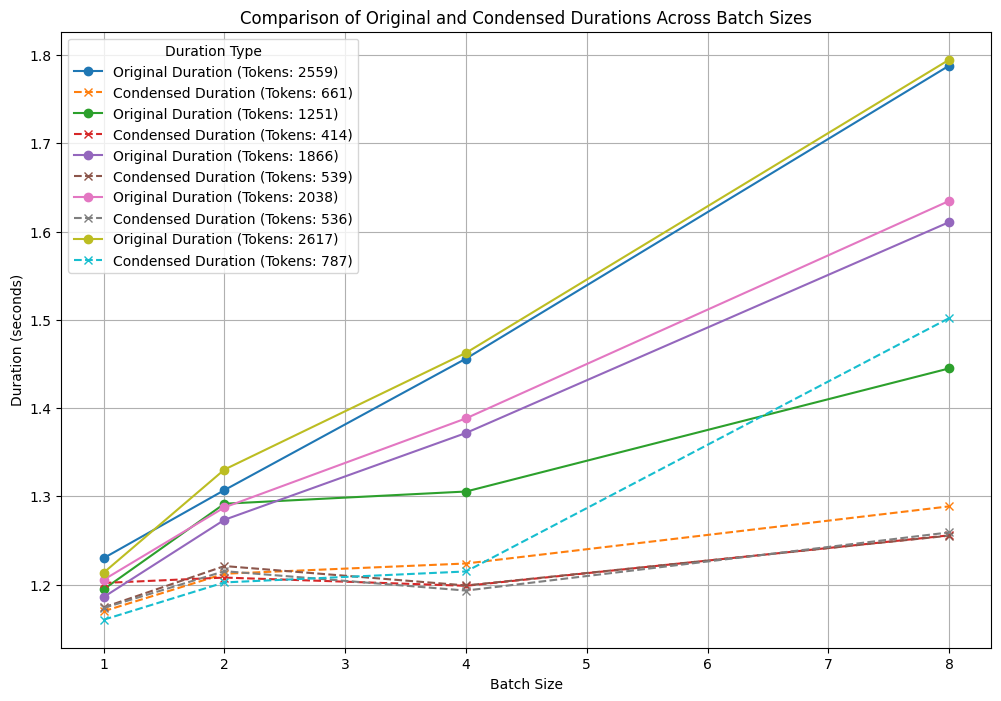

In [14]:
df = pd.DataFrame(all_results)
plt.figure(figsize=(12, 8))

for original_length in df['original_length'].unique():
    subset = df[df['original_length'] == original_length]
    plt.plot(subset['batch_size'], subset['original_duration'], marker='o', linestyle='-', label=f'Original Duration (Tokens: {original_length})')
    plt.plot(subset['batch_size'], subset['condensed_duration'], marker='x', linestyle='--', label=f'Condensed Duration (Tokens: {subset["condensed_length"].iloc[0]})')

plt.xlabel('Batch Size')
plt.ylabel('Duration (seconds)')
plt.title('Comparison of Original and Condensed Durations Across Batch Sizes')
plt.legend(title='Duration Type')
plt.grid()
plt.show()

In [28]:
df[["original_output", "condensed_output"]]

,original_output,condensed_output
0,"Renaud II, Count of Soissons's uncle is Huig II","John of Argues, Count of Soissons.\n\nSource: D"
1,"Renaud II, Count of Soissons's uncle is Willia...","John of Argues, Count of Soissons.\n\nSource: D"
2,"Renaud II, Count of Soissons' uncle is William...","John of Argues, Count of Soissons.\n\nSource: D"
3,"Renaud II, Count of Soissons's uncle is Willia...","John of Argues, Count of Soissons.\n\nSource: D"
4,"Yes, both Rhosgoch (in Wales, United Kingdom) ...","Yes, both villages are located in Iran.\n\n[/\..."
5,"Yes, both Rhosgoch (in Wales, United Kingdom) ...","Yes, both villages are located in Iran.\n\n[/\..."
6,"Yes, both Rhosgoch (located in Wales, United K...","Yes, both villages are located in Iran.\n\n[/\..."
7,"Yes, both Rhosgoch (located in Wales, United K...","Yes, both villages are located in Iran.\n\n[/\..."
8,Guy Arvely Dolsin is older than Altuğ Çelik,Altuğ Çelikbilek is younger.\n\nWho
9,Guy Arvely Dolsin is older than Altuğ Çelik,Altuğ Çelikbilek is younger.\n\nWho
